In [26]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch.nn.init as init
import time
from torch.optim.lr_scheduler import StepLR

In [27]:
# PINN architecture for 2D problem
import torch
import torch.nn as nn

class PINN2D(nn.Module):
    def __init__(self, num_hidden_layers=4, num_neurons_per_layer=128):
        super().__init__()
        
        # Input layer: new input is 5D after transformation
        self.input_layer = nn.Linear(5, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer: output 4 dimensions
        self.output_layer = nn.Linear(num_neurons_per_layer, 4)

        # Activation function
        self.activation = nn.Tanh()
        
        # Initialize weights using Xavier initialization
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

    def forward(self, x, y, t):
        # Step 1: Transform (x, y) using sin/cos
        x_cos = torch.cos(x)
        x_sin = torch.sin(x)
        y_cos = torch.cos(y)
        y_sin = torch.sin(y)

        # Step 2: Concatenate transformed inputs with t
        inputs = torch.cat([x_cos, x_sin, y_cos, y_sin, t], dim=1)

        # Step 3: Pass through network
        outputs = self.activation(self.input_layer(inputs))
        for layer in self.hidden_layers:
            outputs = self.activation(layer(outputs)) + outputs  

        # Step 4: Pass through output layer (4D output)
        outputs = self.output_layer(outputs)  

        # Step 5: Convert (cos(x), sin(x), cos(y), sin(y)) back to (x, y)
        x_pred = torch.atan2(outputs[:, 1], outputs[:, 0])  # atan2(sin, cos)
        y_pred = torch.atan2(outputs[:, 3], outputs[:, 2])  # atan2(sin, cos)

        # Step 6: Stack to return 2D output
        return torch.stack([x_pred, y_pred], dim=1)

In [28]:
class Time_residual(nn.Module):
    def __init__(self, num_hidden_layers=4, num_neurons_per_layer=128):
        super().__init__()
        
        # Input layer: 1D input (time)
        self.input_layer = nn.Linear(1, num_neurons_per_layer)

        # Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output layer: 1D output (time residual)
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        # Activation function
        self.activation = nn.Tanh()
        
        # Initialize weights using Xavier initialization
        nn.init.xavier_normal_(self.input_layer.weight.data)
        nn.init.zeros_(self.input_layer.bias.data)
        
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)
            
        nn.init.xavier_normal_(self.output_layer.weight.data)
        nn.init.zeros_(self.output_layer.bias.data)

    def forward(self, t):
        """
        Forward pass through the network.
        
        Args:
            t (torch.Tensor): Time input of shape [batch_size, 1]
            
        Returns:
            torch.Tensor: Time residual output c_t of shape [batch_size, 1]
        """
        # Pass through network with residual connections
        outputs = self.activation(self.input_layer(t))
        
        for layer in self.hidden_layers:
            layer_output = self.activation(layer(outputs))
            outputs = layer_output + outputs  # Residual connection
        
        # Final output layer
        c_t = self.output_layer(outputs)
        
        return c_t

In [29]:
# PDE residual formula for 2D diffusion equation
def pde_formula(x, y, t, a, c_t):
    # Get the vector field components (not just derivatives)
    a_x = a[:,0:1]  # This should be the x-component
    a_y = a[:,1:2]  # This should be the y-component
    
    # Calculate divergence: ∇·a = ∂a_x/∂x + ∂a_y/∂y
    # First compute derivative of a_x with respect to x
    da_x_dx = grad(a_x, x, grad_outputs=torch.ones_like(a_x), create_graph=True)[0]
    
    # Then compute derivative of a_y with respect to y
    da_y_dy = grad(a_y, y, grad_outputs=torch.ones_like(a_y), create_graph=True)[0]
    
    # Divergence is the sum of these derivatives
    divergence = da_x_dx + da_y_dy

    
    # Compute terms in the PDE
    term1 = c_t
    term2 = torch.cos(x)+torch.cos(y)
    term3 = (a_x*torch.sin(x) + a_y*torch.sin(y))
    term3 = t*term3
    term4 = divergence
    
    # Return the PDE residual
    return (term1 + term2 - term3 + term4)**2

In [30]:
# Initial condition at t=0
def initial_condition_func(x, y):
    # 2D Gaussian pulse
    # return torch.exp(-0.5 * (x**2 + y**2))
    return 1

# Boundary conditions for x boundaries
def boundary_func_x_minus(y, t):
    # Zero value at x=-10 boundary
    return torch.zeros_like(y)

def boundary_func_x_plus(y, t):
    # Zero value at x=10 boundary
    return torch.zeros_like(y)

# Boundary conditions for y boundaries
def boundary_func_y_minus(x, t):
    # Zero value at y=-10 boundary
    return torch.zeros_like(x)

def boundary_func_y_plus(x, t):
    # Zero value at y=10 boundary
    return torch.zeros_like(x)

In [ ]:
# Loss function for 2D PINN with time range [0.1, 1] and vector output correction
def compute_loss(Velocity, Time_residual, device="cuda"):
    # Sample collocation points for PDE residual
    n_pde_points = 10000  # Number of points inside domain

    samples = torch.rand(n_pde_points, 3, device=device)

    # 计算线性变换后的结果
    result = samples * torch.tensor([[2*np.pi, 2*np.pi, 0.9]], device=device) + torch.tensor([[-np.pi, -np.pi, 0.1]], device=device)

    # 按列拆分结果
    x_pde, y_pde, t_pde = result.unbind(dim=1)

    # 保持二维结构（可选，根据需求调整）
    x_pde = x_pde.reshape(-1, 1)
    y_pde = y_pde.reshape(-1, 1)
    t_pde = t_pde.reshape(-1, 1)
    
    # For PDE residual, we need gradients
    x_pde.requires_grad_(True)
    y_pde.requires_grad_(True)
    t_pde.requires_grad_(True)
    
    # PDE residual loss
    u_pde = Velocity(x_pde, y_pde, t_pde)
    c_t = Time_residual(t_pde)
    residual = pde_formula(x_pde, y_pde, t_pde, u_pde, c_t)
    
    pde_loss = torch.mean(residual)
    
    # Initial condition points at t=0.1 (smallest valid t)
    n_ic_points = 1000
    x_ic = torch.rand(n_ic_points, 1, device=device) * 2*np.pi - np.pi    # Range [-10, 10]
    y_ic = torch.rand(n_ic_points, 1, device=device) * 2*np.pi - np.pi    # Range [-10, 10]
    t_ic = torch.ones(n_ic_points, 1, device=device) * 0.1        # t = 0.1 (minimum time)
    u_ic_pred = Velocity(x_ic, y_ic, t_ic)
    u_ic_true = initial_condition_func(x_ic, y_ic)
    ic_loss = torch.sum((u_ic_pred - u_ic_true)**2,dim = 1)
    ic_loss = torch.mean(ic_loss)
    
    # Boundary conditions
    n_bc_points = 1000
    
    # Left boundary (x = -10)
    y_bc_left = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi  # Range [-10, 10]
    t_bc_left = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    x_bc_left = -np.pi * torch.ones_like(y_bc_left, device=device)
    u_bc_left_pred = Velocity(x_bc_left, y_bc_left, t_bc_left)
    u_bc_left_true = boundary_func_x_minus(y_bc_left, t_bc_left)
    bc_loss_left = torch.sum((u_bc_left_pred - u_bc_left_true)**2,dim = 1)
    bc_loss_left = torch.mean(bc_loss_left)
    
    # Right boundary (x = 10)
    y_bc_right = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi # Range [-10, 10]
    t_bc_right = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    x_bc_right = np.pi * torch.ones_like(y_bc_right, device=device)
    u_bc_right_pred = Velocity(x_bc_right, y_bc_right, t_bc_right)
    u_bc_right_true = boundary_func_x_plus(y_bc_right, t_bc_right)
    bc_loss_right = torch.sum((u_bc_right_pred - u_bc_right_true)**2,dim = 1)
    bc_loss_right = torch.mean(bc_loss_right)
    
    # Bottom boundary (y = -10)
    x_bc_bottom = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi  # Range [-10, 10]
    t_bc_bottom = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    y_bc_bottom = -np.pi * torch.ones_like(x_bc_bottom, device=device)
    u_bc_bottom_pred = Velocity(x_bc_bottom, y_bc_bottom, t_bc_bottom)
    u_bc_bottom_true = boundary_func_y_minus(x_bc_bottom, t_bc_bottom)
    bc_loss_bottom = torch.sum((u_bc_bottom_pred - u_bc_bottom_true)**2,dim = 1)
    bc_loss_bottom = torch.mean(bc_loss_bottom)
    
    # Top boundary (y = 10)
    x_bc_top = torch.rand(n_bc_points, 1, device=device) * 2*np.pi - np.pi  # Range [-10, 10]
    t_bc_top = torch.rand(n_bc_points, 1, device=device) * 0.9 + 0.1  # Range [0.1, 1]
    y_bc_top = np.pi * torch.ones_like(x_bc_top, device=device)
    u_bc_top_pred = Velocity(x_bc_top, y_bc_top, t_bc_top)
    u_bc_top_true = boundary_func_y_plus(x_bc_top, t_bc_top)
    bc_loss_top = torch.sum((u_bc_top_pred - u_bc_top_true)**2,dim = 1)
    bc_loss_top = torch.mean(bc_loss_top)
    
    # Total boundary loss
    bc_loss = bc_loss_left + bc_loss_right + bc_loss_bottom + bc_loss_top
    
    # Total loss
    total_loss = pde_loss + ic_loss + bc_loss
    
    return total_loss, pde_loss, ic_loss, bc_loss

In [32]:
# Training function
def train(Velocity, Time_residual, optimizer,scheduler, n_epochs=10000, print_every=1000):
    start_time = time.time()
    loss_history = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        total_loss,pde_loss,ic_loss,bc_loss = compute_loss(Velocity, Time_residual)
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_history.append(total_loss.item())
        
        if epoch % print_every == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch}/{n_epochs} - Time: {elapsed:.2f}s - "
                  f"Loss: {total_loss.item():.6f}, PDE: {pde_loss.item():.6f}, "
                  f"IC: {ic_loss.item():.6f}, BC: {bc_loss.item():.6f}")
    
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    return Velocity, Time_residual, loss_history

Epoch 0/100000 - Time: 0.02s - Loss: 275.989777, PDE: 231.805099, IC: 12.938942, BC: 31.245735
Epoch 100/100000 - Time: 2.12s - Loss: 29.850950, PDE: 3.899172, IC: 9.718334, BC: 16.233444
Epoch 200/100000 - Time: 4.38s - Loss: 24.690142, PDE: 3.090104, IC: 7.798591, BC: 13.801447
Epoch 300/100000 - Time: 6.63s - Loss: 23.343803, PDE: 2.312257, IC: 7.346570, BC: 13.684978
Epoch 400/100000 - Time: 8.88s - Loss: 22.737736, PDE: 1.825890, IC: 7.237154, BC: 13.674693
Epoch 500/100000 - Time: 10.99s - Loss: 22.601482, PDE: 1.495081, IC: 7.251598, BC: 13.854803
Epoch 600/100000 - Time: 13.19s - Loss: 22.628540, PDE: 1.368277, IC: 7.281661, BC: 13.978603
Epoch 700/100000 - Time: 15.30s - Loss: 22.293320, PDE: 1.278855, IC: 7.137515, BC: 13.876949
Epoch 800/100000 - Time: 17.49s - Loss: 22.331146, PDE: 1.259402, IC: 7.173198, BC: 13.898546
Epoch 900/100000 - Time: 19.43s - Loss: 22.443211, PDE: 1.226138, IC: 7.242901, BC: 13.974171
Epoch 1000/100000 - Time: 21.66s - Loss: 22.293324, PDE: 1.1956

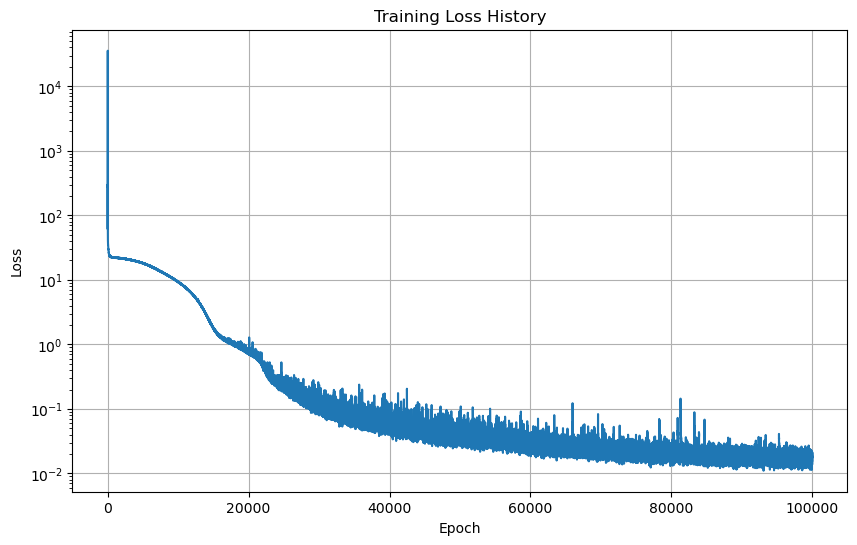

In [33]:
device = torch.device("cuda")
Velocity = PINN2D().to(device)
Time_residual = Time_residual().to(device)
# Optimizer
optimizer = torch.optim.Adam(list(Velocity.parameters()) + list(Time_residual.parameters()), lr=5e-4)
scheduler = StepLR(optimizer, step_size=200, gamma=0.99)
Velocity, Time_residual, loss_history = train(Velocity, Time_residual, optimizer,scheduler,n_epochs=100000, print_every=100)
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.grid(True)
plt.show()

In [37]:
total_params = 0
for p in Velocity.parameters():
    if p.requires_grad:
        total_params += p.numel()
print(f"模型中的可学习参数数量: {total_params}")
for q in Time_residual.parameters():
    if q.requires_grad:
        total_params += q.numel()

# 打印可学习参数数量
print(f"模型中的可学习参数数量: {total_params}")

模型中的可学习参数数量: 67332
模型中的可学习参数数量: 117253


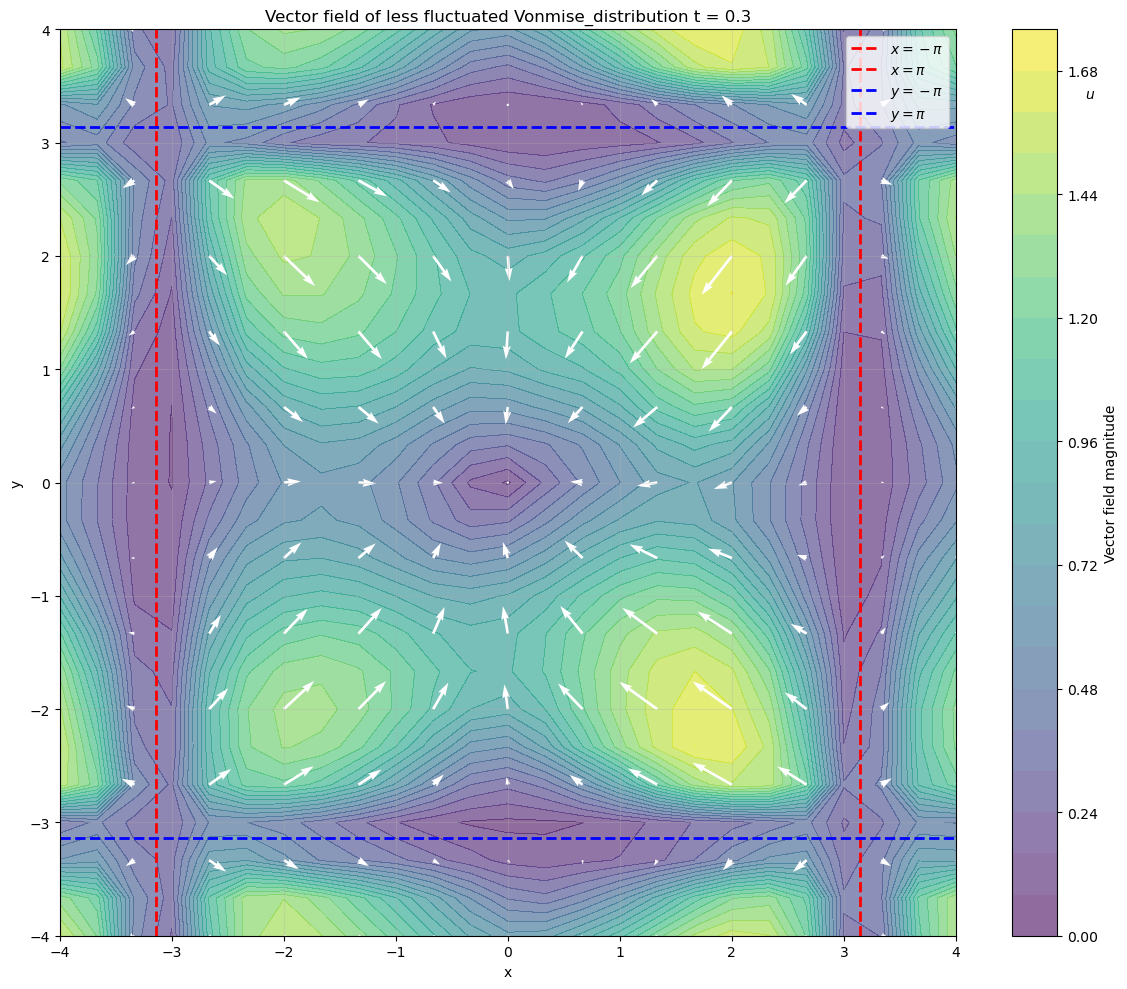

In [41]:
# Function to plot vector field of the solution
"""
Plots the vector field (gradient) of the solution at time t_val.

Args:
    model: Trained PINN model
    t_val: Time value to plot
    grid_size: Number of points in each dimension for visualization
"""
t_val = 0.3
grid_size = 25
# Create a grid for visualization
x = np.linspace(-4, 4, grid_size)
y = np.linspace(-4, 4, grid_size)
X, Y = np.meshgrid(x, y)

# Convert to PyTorch tensors
x_tensor = torch.tensor(X.flatten(), dtype=torch.float32,device = 'cuda').unsqueeze(1).requires_grad_(True)
y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32,device = 'cuda').unsqueeze(1).requires_grad_(True)
t_tensor = torch.ones_like(x_tensor,device = 'cuda') * t_val

# Predict using the model to get vector field
Velocity.eval()
with torch.no_grad():  # No need for gradients here
    vector_field = Velocity(x_tensor, y_tensor, t_tensor)
    
vector_field = vector_field.to('cpu').detach().numpy()
# Extract vector components
u_x = vector_field[:, 0].reshape(X.shape)  # x-component
u_y = vector_field[:, 1].reshape(X.shape)  # y-component

# Calculate magnitude for the contour plot
magnitude = np.sqrt(u_x**2 + u_y**2)

# Plotting
fig = plt.figure(figsize=(12, 10))

# Plot contours of the vector magnitude
contour = plt.contourf(X, Y, magnitude, 20, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='Vector field magnitude')

# Downsample for clearer vector field if needed
skip = 2  # Adjust based on grid_size

# Plot vector field
quiver = plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                   u_x[::skip, ::skip], u_y[::skip, ::skip], 
                   color='white', scale=30, width=0.003)

plt.title(f'Vector field of less fluctuated Vonmise_distribution t = {t_val}')
plt.xlabel('x')
plt.ylabel('y')

pi = np.pi
plt.axvline(-pi, color='red', linestyle='--', linewidth=2, label='$x = -\pi$')
plt.axvline(pi, color='red', linestyle='--', linewidth=2, label='$x = \pi$')
plt.axhline(-pi, color='blue', linestyle='--', linewidth=2, label='$y = -\pi$')
plt.axhline(pi, color='blue', linestyle='--', linewidth=2, label='$y = \pi$')

# Add legend for boundaries
plt.legend(loc='upper right')


# Add vector field scale reference
plt.quiverkey(quiver, 0.9, 0.9, 1, r'$u$', labelpos='E',
               coordinates='figure')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig('pinn_Vonmise_with time norm.png')
# Visualize vector fields at different time points

# for t in [0.1, 0.3, 0.5, 1.0]:


## Save the trained model

In [68]:
torch.save(Velocity, 'PINN_Vonmise_Velocity.pth')
torch.save(Time_residual, 'PINN_VonmiseP_Time_residual.pth')

PicklingError: Can't pickle <class '__main__.Time_residual'>: it's not the same object as __main__.Time_residual

## Check the periodic boundary condition of trained model

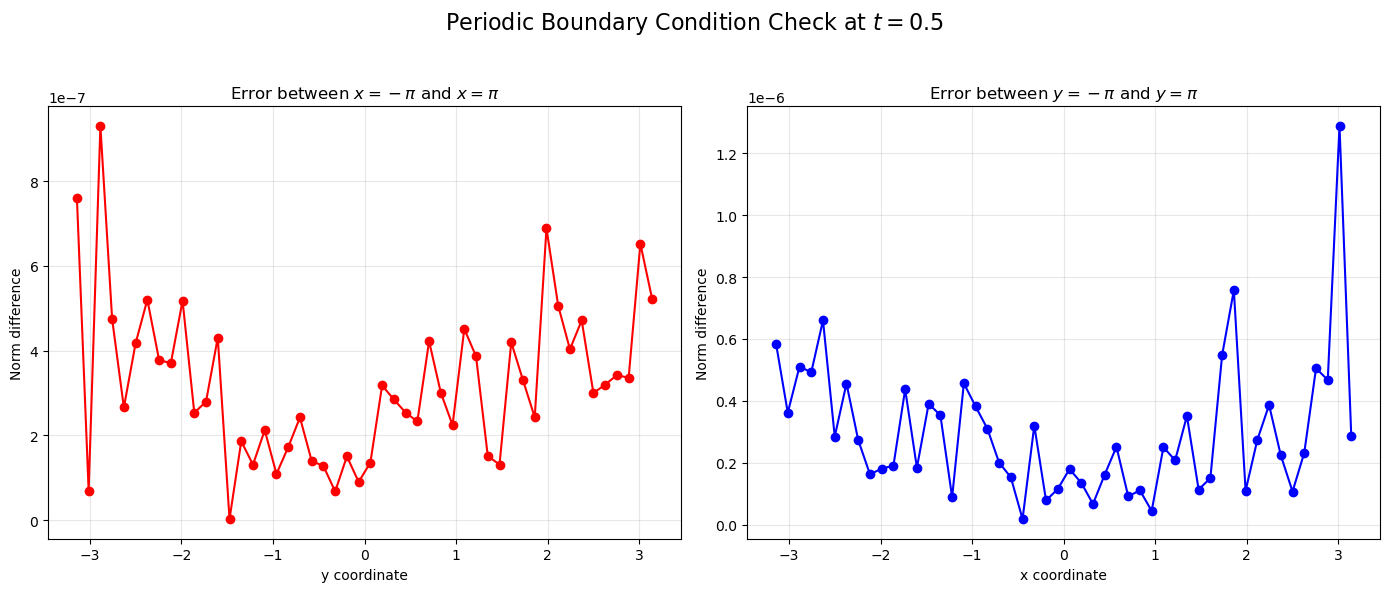

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set device and t value
device = torch.device('cuda')
t_val = 0.5
pi = np.pi
n_samples = 50  # number of points along the boundary

# ============================
# Check periodicity in x-direction
# ============================
# For each y in [-pi, pi], compare vector_field at x = -pi and x = pi.
y_vals = np.linspace(-pi, pi, n_samples)

# Create tensors for boundary evaluation at x = -pi and x = pi.
x_left = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
x_right = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y_vals, dtype=torch.float32, device=device).unsqueeze(1)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

# Evaluate the model on the left and right boundaries.
trained_model.eval()
with torch.no_grad():
    vector_left = trained_model(x_left, y_tensor, t_tensor)
    vector_right = trained_model(x_right, y_tensor, t_tensor)

# Move to CPU and convert to NumPy arrays.
vector_left = vector_left.cpu().numpy()
vector_right = vector_right.cpu().numpy()

# Compute the norm of the difference for each y coordinate.
error_x = np.linalg.norm(vector_left - vector_right, axis=1)

# ============================
# Check periodicity in y-direction
# ============================
# For each x in [-pi, pi], compare vector_field at y = -pi and y = pi.
x_vals = np.linspace(-pi, pi, n_samples)
x_tensor = torch.tensor(x_vals, dtype=torch.float32, device=device).unsqueeze(1)
y_bottom = torch.full((n_samples, 1), -pi, dtype=torch.float32, device=device)
y_top = torch.full((n_samples, 1), pi, dtype=torch.float32, device=device)
t_tensor = torch.full((n_samples, 1), t_val, dtype=torch.float32, device=device)

with torch.no_grad():
    vector_bottom = trained_model(x_tensor, y_bottom, t_tensor)
    vector_top = trained_model(x_tensor, y_top, t_tensor)

vector_bottom = vector_bottom.cpu().numpy()
vector_top = vector_top.cpu().numpy()

# Compute the norm of the difference for each x coordinate.
error_y = np.linalg.norm(vector_bottom - vector_top, axis=1)

# ============================
# Visualization of the periodicity check results
# ============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the error along the x-boundaries as a function of y.
axes[0].plot(y_vals, error_x, 'o-', color='red')
axes[0].set_title('Error between $x=-\pi$ and $x=\pi$')
axes[0].set_xlabel('y coordinate')
axes[0].set_ylabel('Norm difference')
axes[0].grid(True, alpha=0.3)

# Plot the error along the y-boundaries as a function of x.
axes[1].plot(x_vals, error_y, 'o-', color='blue')
axes[1].set_title('Error between $y=-\pi$ and $y=\pi$')
axes[1].set_xlabel('x coordinate')
axes[1].set_ylabel('Norm difference')
axes[1].grid(True, alpha=0.3)

fig.suptitle(f'Periodic Boundary Condition Check at $t={t_val}$', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## call the saved model

In [28]:
model = torch.load("PINN_Vonmise.pth")
model

PINN2D(
  (input_layer): Linear(in_features=3, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0-5): 6 x Linear(in_features=64, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
  (activation): Tanh()
)

## Define the integral function

In [34]:
def solve_ivp_torch(fun: nn.Module, t_span, y0, method='RK45', rtol=1e-3, atol=1e-6):
    """
    A batch-friendly ODE solver using SciPy's solve_ivp internally.
    NOTE: Results are not differentiable through PyTorch autograd.
    """
    B, ND = y0.shape
    device = y0.device

    def fun_wrapper(t, y):
        # 1) Convert incoming y (numpy array) to a PyTorch tensor
        y_torch = torch.from_numpy(y).float().to('cuda').reshape(-1, ND)

        # 2) Convert scalar t to a tensor of shape (B, 1)
        t_torch = torch.ones_like(y_torch[:, :1], device='cuda') * t

        # 3) Evaluate the user-specified function (the ODE’s right-hand side)
        vt = fun(y_torch[:,0:1],y_torch[:,1:2], t_torch)

        # 4) Convert the result back to numpy, flatten
        return vt.detach().cpu().numpy().reshape(-1)

    # Flatten initial y0 to shape (B*ND,)
    import numpy as np
    from scipy.integrate import solve_ivp

    y0_np = y0.detach().cpu().numpy().reshape(-1)

    sol = solve_ivp(
        fun_wrapper,
        t_span,
        y0_np,
        method=method,
        rtol=rtol,
        atol=atol
    )

    # Return the final solution at t_span[-1], shape (B, ND)
    final_y = sol.y[:, -1]
    final_y_torch = torch.from_numpy(final_y).float().to(device).reshape(B, ND)
    return final_y_torch

torch.Size([200000, 2])
x range: -3.1415672302246094 3.141557455062866
y range: -3.1415841579437256 3.1415741443634033


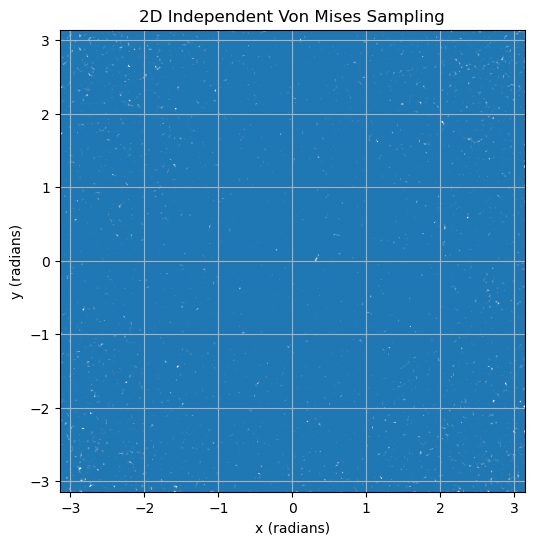

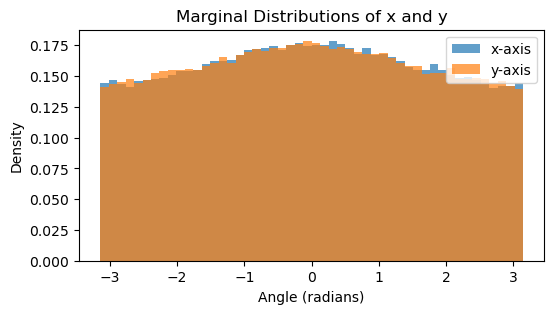

In [37]:
import torch
import math
import matplotlib.pyplot as plt

import torch
import math
import matplotlib.pyplot as plt

# 设定样本数量
num_samples = 200000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 0.1   # x 方向集中度
kappa_y = 0.1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

torch.Size([200000, 2])
x range: -3.141554832458496 3.1414549350738525
y range: -3.141423463821411 3.141491174697876


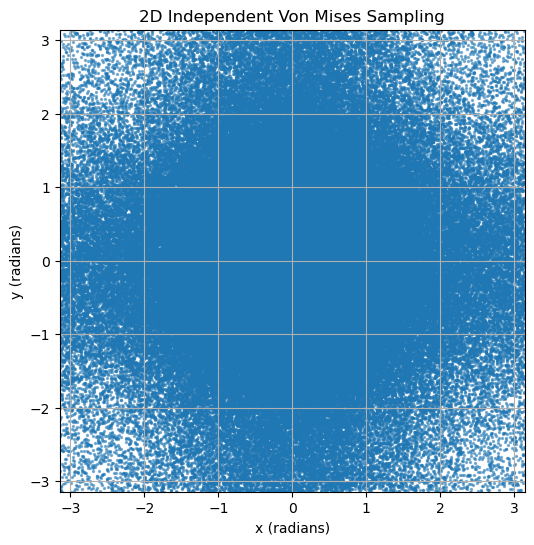

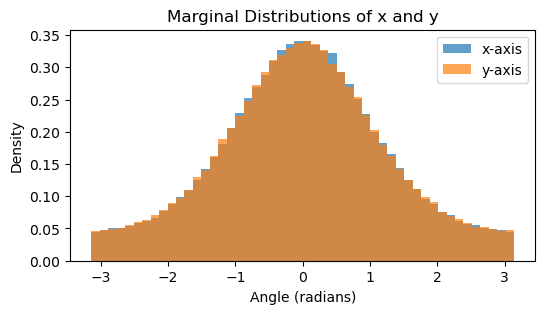

In [38]:
num_samples = 200000

# 设定 Von Mises 分布参数
mu_x = 0.0      # x 方向均值角度
mu_y = 0.0      # y 方向均值角度
kappa_x = 1   # x 方向集中度
kappa_y = 1   # y 方向集中度

# 1. 分别从两个独立的 Von Mises 分布中采样 x 和 y
dist_x = torch.distributions.VonMises(mu_x, kappa_x)
dist_y = torch.distributions.VonMises(mu_y, kappa_y)

samples_x = dist_x.sample((num_samples,))
samples_y = dist_y.sample((num_samples,))

# 2. 确保所有样本严格在 [-π, π] 盒子里（一般不需要，因为 PyTorch 采样默认在 [-π, π]）
samples_x = torch.remainder(samples_x + math.pi, 2 * math.pi) - math.pi
samples_y = torch.remainder(samples_y + math.pi, 2 * math.pi) - math.pi

# 3. 组合成 2D 样本
samples_2d_concentrated = torch.stack((samples_x, samples_y), dim=1)  # shape: [10000, 2]

# 输出形状检查
print(samples_2d_concentrated.shape)  # 应该是 [10000, 2]
print("x range:", samples_x.min().item(), samples_x.max().item())
print("y range:", samples_y.min().item(), samples_y.max().item())

# 4. 可视化结果
plt.figure(figsize=(6,6))
plt.scatter(samples_x.numpy(), samples_y.numpy(), s=2, alpha=0.5)
plt.xlim(-math.pi, math.pi)
plt.ylim(-math.pi, math.pi)
plt.xlabel("x (radians)")
plt.ylabel("y (radians)")
plt.title("2D Independent Von Mises Sampling")
plt.grid(True)
plt.show()

# 5. 分别绘制 x 和 y 的直方图
plt.figure(figsize=(6,3))
plt.hist(samples_x.numpy(), bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(samples_y.numpy(), bins=50, alpha=0.7, density=True, label="y-axis")
plt.xlabel("Angle (radians)")
plt.ylabel("Density")
plt.title("Marginal Distributions of x and y")
plt.legend()
plt.show()

In [39]:
# Suppose ND=2, so our state y = (x, v) or something like that
# We'll define a network with input_dim=ND+1=3, hidden_dim=16, output_dim=ND=2

# Integrate from t = 0 to t = 1
t_span = (0.1, 1.0)

# Solve
final_y = solve_ivp_torch(Velocity, t_span, samples_2d)
print(final_y.shape)

torch.Size([200000, 2])


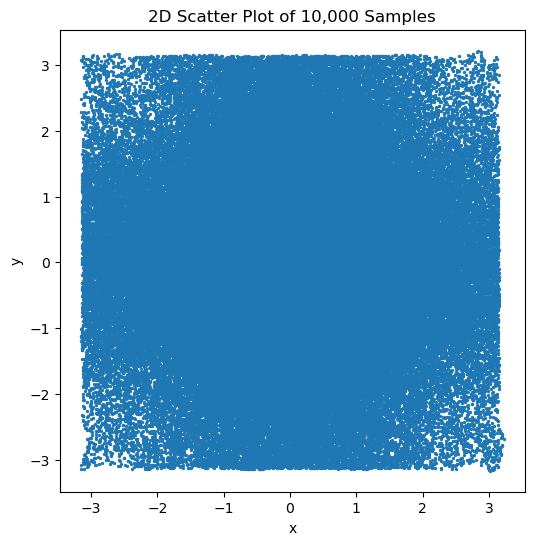

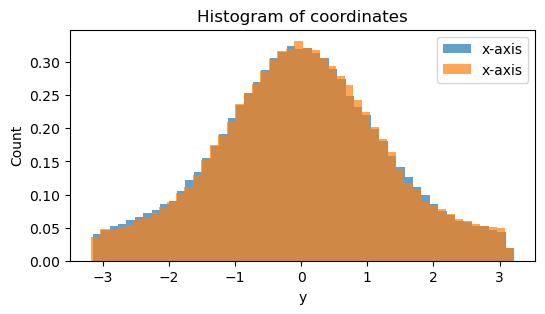

In [40]:
samples_np = final_y.cpu().numpy()

x_vals = samples_np[:, 0]
y_vals = samples_np[:, 1]

# 1) Scatter plot of (x, y)
plt.figure(figsize=(6,6))
plt.scatter(x_vals, y_vals, s=2)  # s=2 => smaller marker size
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Scatter Plot of 10,000 Samples")
plt.show()

# 2) Histogram of x
plt.figure(figsize=(6,3))
plt.hist(x_vals, bins=50, alpha=0.7, density=True, label="x-axis")
plt.hist(y_vals, bins=50, alpha=0.7, density=True, label="x-axis")
plt.xlabel("y")
plt.ylabel("Count")
plt.title("Histogram of coordinates")
plt.legend()
plt.show()

In [41]:
kappa = torch.linspace(0.1, 1.0, steps=100, requires_grad=True)

Time_residual.eval()
with torch.no_grad():  # No need for gradients here
    c_test = Time_residual(kappa.view(100,1).to('cuda'))
c_test

tensor([[-0.0528],
        [-0.0598],
        [-0.0670],
        [-0.0744],
        [-0.0819],
        [-0.0895],
        [-0.0974],
        [-0.1053],
        [-0.1135],
        [-0.1217],
        [-0.1302],
        [-0.1387],
        [-0.1475],
        [-0.1563],
        [-0.1653],
        [-0.1744],
        [-0.1836],
        [-0.1930],
        [-0.2024],
        [-0.2120],
        [-0.2216],
        [-0.2313],
        [-0.2411],
        [-0.2510],
        [-0.2609],
        [-0.2708],
        [-0.2808],
        [-0.2908],
        [-0.3008],
        [-0.3108],
        [-0.3207],
        [-0.3307],
        [-0.3406],
        [-0.3504],
        [-0.3602],
        [-0.3699],
        [-0.3796],
        [-0.3891],
        [-0.3986],
        [-0.4079],
        [-0.4172],
        [-0.4263],
        [-0.4353],
        [-0.4441],
        [-0.4528],
        [-0.4614],
        [-0.4698],
        [-0.4781],
        [-0.4862],
        [-0.4942],
        [-0.5020],
        [-0.5096],
        [-0.

In [43]:
# Define the function ln(2 * pi * I0(kappa))
f = torch.log(2 * torch.pi * torch.special.i0(kappa))

# Compute the derivative (gradient) w.r.t. kappa by summing f and calling autograd
gradient = torch.autograd.grad(outputs=f.sum(), inputs=kappa)[0]
gradient

tensor([0.0499, 0.0545, 0.0590, 0.0635, 0.0680, 0.0725, 0.0770, 0.0815, 0.0860,
        0.0905, 0.0950, 0.0995, 0.1040, 0.1084, 0.1129, 0.1174, 0.1218, 0.1263,
        0.1307, 0.1351, 0.1395, 0.1439, 0.1483, 0.1527, 0.1571, 0.1615, 0.1658,
        0.1702, 0.1745, 0.1789, 0.1832, 0.1875, 0.1918, 0.1961, 0.2004, 0.2046,
        0.2089, 0.2131, 0.2174, 0.2216, 0.2258, 0.2300, 0.2342, 0.2383, 0.2425,
        0.2466, 0.2508, 0.2549, 0.2590, 0.2631, 0.2671, 0.2712, 0.2752, 0.2793,
        0.2833, 0.2873, 0.2912, 0.2952, 0.2992, 0.3031, 0.3070, 0.3109, 0.3148,
        0.3187, 0.3225, 0.3264, 0.3302, 0.3340, 0.3378, 0.3415, 0.3453, 0.3490,
        0.3527, 0.3564, 0.3601, 0.3638, 0.3674, 0.3711, 0.3747, 0.3783, 0.3819,
        0.3854, 0.3890, 0.3925, 0.3960, 0.3995, 0.4030, 0.4064, 0.4098, 0.4133,
        0.4166, 0.4200, 0.4234, 0.4267, 0.4301, 0.4334, 0.4366, 0.4399, 0.4432,
        0.4464])

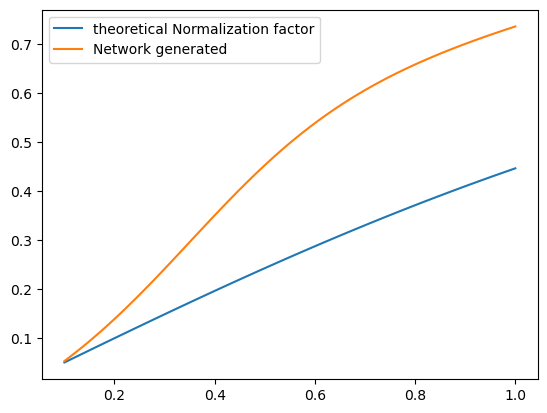

In [44]:
plt.plot(np.linspace(0.1, 1.0,100),gradient.numpy(), label = 'theoretical Normalization factor')
plt.plot(np.linspace(0.1, 1.0,100),-c_test.cpu().numpy(), label = 'Network generated')
plt.legend()
plt.show()

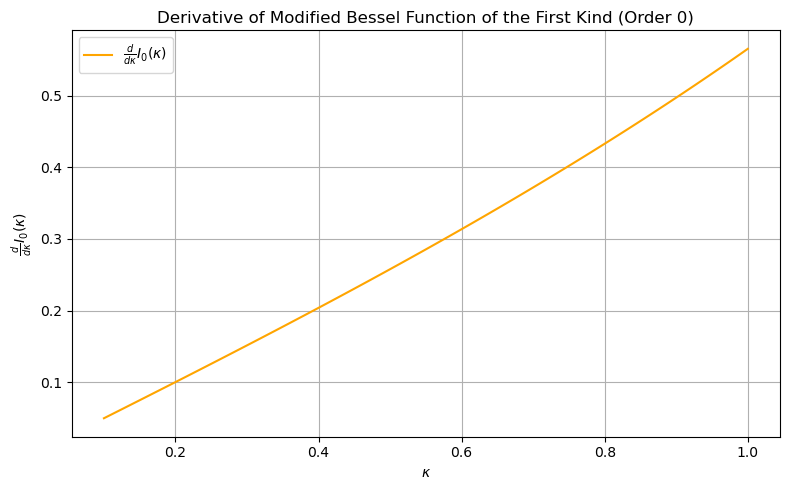

In [40]:
from scipy.special import ivp

# Compute the derivative of the modified Bessel function of the first kind of order 0
dI0_dkappa = ivp(0, kappa.detach()).numpy()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(kappa.detach().numpy(), dI0_dkappa, label=r"$\frac{d}{d\kappa}I_0(\kappa)$", color="orange")
plt.xlabel(r'$\kappa$')
plt.ylabel(r"$\frac{d}{d\kappa}I_0(\kappa)$")
plt.title('Derivative of Modified Bessel Function of the First Kind (Order 0)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()